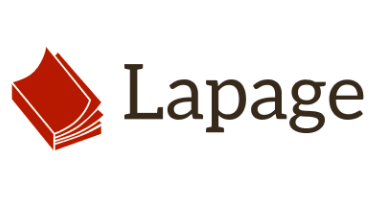

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pylab as pl
import numpy as np
import plotly.express as px
import statistics
from datetime import datetime, date
from scipy import stats
from scipy.stats import pareto
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from abc_analysis import abc_analysis, abc_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Scénario
Vous êtes consultant Data Analyst chez Lapage, une grande librairie généraliste en ligne très réputée. Vous êtes directement rattaché au service Marketing.
Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Mission

Une analyse des différents indicateurs de vente, qui a été demandée directement par Antoine. Je t’ai mis en pièce jointe l’e-mail qu’il m’a envoyé résumant ses demandes.
<br>
* Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 
* Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale ?
* Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
Enfin, j’aimerais avoir quelques informations sur les profils de nos clients, et également la
répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
Une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. Pour cela, je t’invite à voir avec Julie, qui te précisera directement ses demandes à ce niveau.


Regarder en particulier :
* Le lien entre le genre d’un client et les catégories des livres achetés
* Le lien entre l’âge des clients et le montant total des achats
* La fréquence d’achat
* La taille du panier moyen et les catégories des livres achetés

**Détail du nettoyage des données : vous présenterez ici l’ensemble des choix et actions que vous avez réalisés afin d’obtenir un jeu de données exploitable.
Restitution de l’analyse : les chiffres clés, KPI, graphiques générés, corrélations calculées, etc.**

* Réaliser une analyse bivariée pour interpréter des données
* Réaliser un test statistique
* Analyser des séries temporelles

# Données
* Compréhension des données

## Compréhension des données
Chargement des 3 fichiers csv avec la fonction read_csv de Pandas
<br>Utilisation des fonctions **head(), info(), describe()**

In [2]:
df_customers= pd.read_csv("customers.csv")
df_products= pd.read_csv("products.csv")
df_transactions= pd.read_csv("transactions.csv")

In [3]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
df_customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [6]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [8]:
df_products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [9]:
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [10]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [11]:
df_transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


# Nettoyage des données

## df_customers

In [12]:
df_customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [13]:
df_customers['sex'].value_counts()

f    4491
m    4132
Name: sex, dtype: int64

In [14]:
df_customers['birth'].value_counts()

2004    440
1979    215
1988    207
1986    203
1978    199
       ... 
1935      8
1932      6
1930      4
1931      4
1929      3
Name: birth, Length: 76, dtype: int64

In [15]:
df_customers['client_id'].value_counts()

c_5796    1
c_2495    1
c_7248    1
c_349     1
c_330     1
         ..
c_6298    1
c_1580    1
c_557     1
c_3960    1
c_1526    1
Name: client_id, Length: 8623, dtype: int64

In [16]:
df_customers['client_id'].nunique()

8623

In [17]:
df_customers[df_customers.duplicated(keep=False)]

,client_id,sex,birth



Pas doublons, les valeurs client_id sont uniques à 8623
<br> Le fichier df_customers est propre, sans valeurs aberantes == aucun nettoyage necessaire

## df_products

In [18]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [19]:
#fonction describe nous informe sur une valeur minimale à -1eur
df_products['price'].sort_values(ascending=True)

731      -1.00
2355      0.62
2272      0.62
370       0.66
1211      0.77
         ...  
2779    233.54
1436    236.99
394     247.22
724     254.44
947     300.00
Name: price, Length: 3287, dtype: float64

In [20]:
#filtre des rows ou le prix inférieur à 0
df_products[df_products['price']<0]

,id_prod,price,categ
731,T_0,-1.0,0


In [21]:
#nettoyge de l'index 731
df_products.drop(index=731, axis=0, inplace=True)

In [22]:
df_products["categ"].value_counts()

0    2308
1     739
2     239
Name: categ, dtype: int64

In [23]:
#df_products["categ"] = df_products["categ"].astype("object")
#df_products.dtypes

In [24]:
df_products["id_prod"].value_counts()

0_1396    1
1_357     1
1_219     1
0_325     1
0_690     1
         ..
0_862     1
0_143     1
0_1609    1
0_321     1
0_1731    1
Name: id_prod, Length: 3286, dtype: int64

In [25]:
df_products["id_prod"].nunique()

3286

In [26]:
df_products[df_products.duplicated(keep=False)]

,id_prod,price,categ


Supression de la ligne 731 du fichier product ou le prix = -1.0 eur
<br>Pas doublons, les valeurs id prod sont uniques à 8386
<br> Modification du type de la feature categorie

## df_transactions

In [27]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [28]:
df_transactions['date'].value_counts()

test_2021-03-01 02:30:02.237413    13
test_2021-03-01 02:30:02.237414     8
test_2021-03-01 02:30:02.237428     8
test_2021-03-01 02:30:02.237443     8
test_2021-03-01 02:30:02.237427     8
                                   ..
2022-12-21 16:36:52.717599          1
2022-11-01 05:16:44.521742          1
2021-05-01 06:02:04.763264          1
2021-04-24 14:33:36.340246          1
2023-02-06 23:58:41.848736          1
Name: date, Length: 679371, dtype: int64

In [29]:
df_transactions[df_transactions.duplicated(keep=False)]

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
19312,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0
...,...,...,...,...
653098,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [30]:
# fonction split pour création d'une feature temporaire
df_transactions["Date_Test"] = df_transactions["date"].apply(
    lambda x: x.split('-')[0])

# visualisation des valeurs après le split '-'
df_transactions["Date_Test"].value_counts()

2022         346500
2021         278335
2023          54497
test_2021       200
Name: Date_Test, dtype: int64

In [31]:
# Elimination des valeurs Test
df_transactions = df_transactions[df_transactions["Date_Test"] != "test_2021"]

In [32]:
# fonction split
df_transactions["Date"] = df_transactions["date"].apply(lambda x: x.split()[0])

# To datetime a lieu d'object
df_transactions.Date = pd.to_datetime(df_transactions.Date)

# info()
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679531
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679332 non-null  object        
 1   date        679332 non-null  object        
 2   session_id  679332 non-null  object        
 3   client_id   679332 non-null  object        
 4   Date_Test   679332 non-null  object        
 5   Date        679332 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 36.3+ MB


In [33]:
# Suppression de la feature temporaire 'date _test'
df_transactions.drop(['Date_Test'], axis=1, inplace=True)

# verification des valeurs uniques
df_transactions.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
Date             730
dtype: int64

Dans la table **transactions** nous avons:
* id_prod = 3266 contre dans la table product, id_prod = 3286 ; delta de 20 row 
* id_client = 8600 contre dans la table customer, id_client = 8623; delta de 23 row 

## Verification des id prod non présents dans notre table df_transation

id_prod = 3266 contre dans la table product, id_prod = 3286 ; delta de 20 row 

In [34]:
# Création d'une liste avec uniquement les id_prod de la table transaction
id_prod_in_transactions = df_transactions['id_prod'].to_list()

# methode isin
id_prod_transactions_in_products = df_products[df_products["id_prod"].isin(
    id_prod_in_transactions) == False]

# verification des id_prod unique
id_prod_transactions_in_products.nunique()

id_prod    21
price      19
categ       3
dtype: int64

In [35]:
# Somme produits non vendus
somme_id_prod_non_vendus = id_prod_transactions_in_products['price'].sum()

# Affichage avec la fonction print() somme produits non vendus
print(
    f'La valeur des id_prod non vendus est de : {round(somme_id_prod_non_vendus,2)} euros')

La valeur des id_prod non vendus est de : 795.28 euros


Il y a 21 id_prod qui ne sont pas presents dans notre table transaction. Nous supposons qu'il s'agit des produits non vendus.
<br>En revanche, il y a un delta de 1, car nous devions retrouver ici nos 20 id_prod or nous avons 21 id_prod
<br>*Vérification du delta dans les id_prod de la table transaction*

In [36]:
# On exclut les 21 id_prod
df_products = df_products[df_products["id_prod"].isin(
    id_prod_in_transactions) == True]

# nunique()
df_transactions.nunique()

id_prod         3266
date          679332
session_id    342315
client_id       8600
Date             730
dtype: int64

### Verification des id prod de la table transaction non présents dans notre table df_products

In [37]:
# Création d'une liste avec uniquement les id_prod de la table transaction
id_prod_products = df_products['id_prod'].to_list()

# methode isin
id_prod_transactions = df_transactions[df_transactions["id_prod"].isin(
    id_prod_products) == False]

id_prod_transactions

,id_prod,date,session_id,client_id,Date
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,2022-09-23
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,2022-07-23
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,2022-12-03
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,2021-08-16
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,2022-07-16
...,...,...,...,...,...
669730,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,2021-08-25
670682,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,2022-03-06
671286,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,2022-05-16
675679,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,2022-02-11


In [38]:
# visualisation nunique pour observer id prod 0_2245 sur les autres features
id_prod_transactions.nunique()

id_prod         1
date          221
session_id    221
client_id     100
Date          194
dtype: int64

In [39]:
# visualisation de l'id prod 0_2245 dans la table df_product
df_products[df_products['id_prod']=='0_2245']

,id_prod,price,categ


Nous observons que l'id_prod **0_2245** de notre table transaction compte 221  rows
<br>En revanche, il n'est pas présent dans la table product d'ou le delta de 1 que nous avions précedemment
<br>

In [40]:
# On exclut l'id_prod 0_2245
df_transactions = df_transactions[df_transactions["id_prod"].isin(
    id_prod_products) == True]

# nunique()
df_transactions.nunique()

id_prod         3265
date          679111
session_id    342275
client_id       8600
Date             730
dtype: int64

Nous avons bien un delta de 21 entre nos deux tables 3265 contre 3286
* 20 produits non vendus n'apparaissant pas dans la table transaction
* 1 id_prod présent dans la table transaction et non dans la table product > elimination de cette valeur

Nous conservons uniquement 3265 rows

### Verification des id_client dans df_customers

* id_client = 8600 dans la table transaction
* id_client = 8623 dans la table customer
<br>Delta de 23 row 

In [41]:
# Création d'une liste avec uniquement les id_client de la table transaction
id_client_in_customers = df_customers['client_id'].to_list()

# methode isin
id_client_customers_in_transaction = df_transactions[df_transactions["client_id"].isin(
    id_client_in_customers) == False]

# visualisation des id_client non présent dans df_transaction
id_client_customers_in_transaction

,id_prod,date,session_id,client_id,Date


Notre table transaction comporte tous les client_id presents dans df_customers, aucune valeurs manquantes
<br> C'est à dire qu'il n'y a pas d'id_client dans df_transaction qui n'existeraient pas dans id_customers

### Verification des id client dans df_transation

In [42]:
# Création d'une liste avec uniquement les id_client de la table transaction
id_client_in_transactions = df_transactions['client_id'].to_list()

# methode isin
id_client_transactions_in_customers = df_customers[df_customers["client_id"].isin(
    id_client_in_transactions) == False]

# verification des id_client unique
id_client_transactions_in_customers.nunique()

client_id    23
sex           2
birth        15
dtype: int64

In [43]:
nombre_clients_sans_transaction = len(
    id_client_transactions_in_customers['client_id'])

In [44]:
# Affichage avec la fonction print() du nombre de clients sans transactions
print(
    f'Il y a : {nombre_clients_sans_transaction} clients ne figurent pas dans notre df_transaction')

Il y a : 23 clients ne figurent pas dans notre df_transaction


Il y a 23 client_id qui ne sont pas presents dans notre table transaction. Nous supposons qu'il s'agit des clients sans transaction associée.

In [45]:
# On exclut les 23 id_client sans transactions avec la fonction isin()
df_customers = df_customers[df_customers["client_id"].isin(
    id_client_in_transactions) == True]

# Verification des id_clientunique
df_customers.nunique()

client_id    8600
sex             2
birth          76
dtype: int64

Nous terminons le nettoyage de nos données en eliminant les id_clients sans transaction associée
<br> Notre fichier df_customers comporte 8600 id clients après elimination des 23 clients ne se retrouvant pas dans df_transaction

## Rapprochement des tables

In [46]:
df_products.nunique()

id_prod    3265
price      1442
categ         3
dtype: int64

In [47]:
df_customers.nunique()

client_id    8600
sex             2
birth          76
dtype: int64

In [48]:
df_transactions.nunique()

id_prod         3265
date          679111
session_id    342275
client_id       8600
Date             730
dtype: int64

Après la phase de nettoyage nous obtenons un jeu de donnée cohérent avec une similitude entre id_prod et id_client sur les 3 tables

In [49]:
df_transactions_customers = pd.merge(
    df_transactions, df_customers, on='client_id')
df_transactions_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679110
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  object        
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   Date        679111 non-null  datetime64[ns]
 5   sex         679111 non-null  object        
 6   birth       679111 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 41.4+ MB


In [50]:
df_transactions_customers_products = pd.merge(
    df_transactions_customers, df_products, on='id_prod')
df_transactions_customers_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679110
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  object        
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   Date        679111 non-null  datetime64[ns]
 5   sex         679111 non-null  object        
 6   birth       679111 non-null  int64         
 7   price       679111 non-null  float64       
 8   categ       679111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 51.8+ MB


In [51]:
df_transactions_customers_products.head()

,id_prod,date,session_id,client_id,Date,sex,birth,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,2022-05-20,f,1986,4.18,0
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,2021-07-20,f,1986,4.18,0
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,2022-08-20,f,1986,4.18,0
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,2021-05-09,f,1968,4.18,0
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,2022-05-30,f,1968,4.18,0


In [52]:
df_transactions_customers_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679110
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  object        
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   Date        679111 non-null  datetime64[ns]
 5   sex         679111 non-null  object        
 6   birth       679111 non-null  int64         
 7   price       679111 non-null  float64       
 8   categ       679111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 51.8+ MB


In [53]:
# duplicate
df_transactions_customers_products.loc[df_transactions_customers_products.duplicated(
    keep=False), :]

,id_prod,date,session_id,client_id,Date,sex,birth,price,categ


## Time Series et création de feature

In [54]:
# Set_index
df_transactions_customers_products = df_transactions_customers_products.set_index(
    'Date')

# création d'une nouvelle feature avec l'année
df_transactions_customers_products['ANNEE'] = df_transactions_customers_products.index.year

# création d'une nouvelle feature avec le nom du mois
df_transactions_customers_products['MOIS'] = df_transactions_customers_products.index.month_name(
)

# création d'une nouvelle feature avec le nom du jour
df_transactions_customers_products['JOUR'] = df_transactions_customers_products.index.day_name(
)

In [55]:
# Birth date
today = date.today()
df_transactions_customers_products['age'] = df_transactions_customers_products.apply(
    lambda x: today.year-x['birth'], axis=1)

In [56]:

df_transactions_customers_products["categ"] = df_transactions_customers_products["categ"].astype("object")

df_transactions_customers_products["ANNEE"] = df_transactions_customers_products["ANNEE"].astype("object")

In [57]:
df_transactions_customers_products.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679111 entries, 2022-05-20 to 2021-03-08
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679111 non-null  object 
 1   date        679111 non-null  object 
 2   session_id  679111 non-null  object 
 3   client_id   679111 non-null  object 
 4   sex         679111 non-null  object 
 5   birth       679111 non-null  int64  
 6   price       679111 non-null  float64
 7   categ       679111 non-null  object 
 8   ANNEE       679111 non-null  object 
 9   MOIS        679111 non-null  object 
 10  JOUR        679111 non-null  object 
 11  age         679111 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 67.4+ MB


In [58]:
df_transactions_customers_products.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,ANNEE,MOIS,JOUR,age
Date,,,,,,,,,,,,
2022-05-20,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,May,Friday,36
2021-07-20,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986,4.18,0,2021,July,Tuesday,36
2022-08-20,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986,4.18,0,2022,August,Saturday,36
2021-05-09,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968,4.18,0,2021,May,Sunday,54
2022-05-30,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968,4.18,0,2022,May,Monday,54


# Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 

In [59]:
# Calcul du CA total
CA_total = df_transactions_customers_products["price"].sum()

# Affichage CA  total avec la fonction print()
print(
    f'Le chiffre d’affaires total réalisé est de : {round(CA_total ,2)} euros')

Le chiffre d’affaires total réalisé est de : 11853728.68 euros


In [60]:
# Affichage CA par catégorie avec la fonction groupby()
CA_categ = df_transactions_customers_products.groupby('categ')['price'].sum()

In [61]:
# Affichage CA par categorie avec la fonction print()
print(
    f'Le chiffre d’affaires réalisé par la catégorie 0 est de : {round(CA_categ[0],2)} euros')
print(
    f'Le chiffre d’affaires réalisé par la catégorie 1 est de : {round(CA_categ[1],2)} euros')
print(
    f'Le chiffre d’affaires réalisé par la catégorie 2 est de : {round(CA_categ[2],2)} euros')

Le chiffre d’affaires réalisé par la catégorie 0 est de : 4419730.97 euros
Le chiffre d’affaires réalisé par la catégorie 1 est de : 4653722.69 euros
Le chiffre d’affaires réalisé par la catégorie 2 est de : 2780275.02 euros


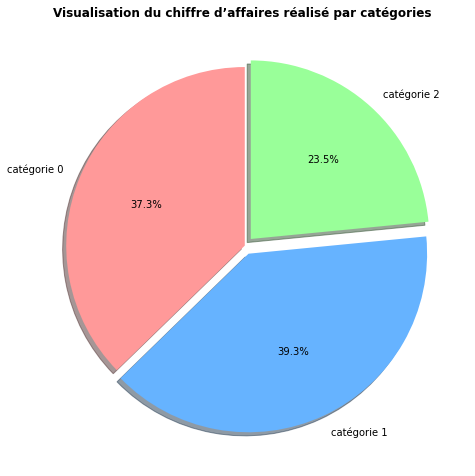

In [62]:
fig = plt.figure(figsize=[8, 12])
labels = 'catégorie 0', 'catégorie 1', 'catégorie 2'

sizes = [CA_categ[0],
         CA_categ[1],
         CA_categ[2]]

explode = (0, 0.05, 0.05)
ax = fig.add_subplot()

# add colors
colors = ['#ff9999', '#66b3ff', '#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title(
    'Visualisation du chiffre d’affaires réalisé par catégories ', fontweight="bold")
plt.show()

In [63]:
# Calcul du nombre de ventes
Nb_vente_total = df_transactions_customers_products["price"].count()

# Affichage nombre de ventes total avec la fonction print()
print(
    f'Le nombre total de ventes réalisé est de : {round(Nb_vente_total ,2)} articles')

Le nombre total de ventes réalisé est de : 679111 articles


In [64]:
#Affichage nombre de ventes par catégorie avec la fonction groupby()
Nb_vente_categ=df_transactions_customers_products.groupby('categ')['price'].count()

#Affichage nb ventes par categorie avec la fonction print()
print(f'Le nombre total de ventes réalisés par la catégorie 0 est de : {round(Nb_vente_categ[0],2)} produits')
print(f'Le nombre total de ventes réalisés par la catégorie 1 est de : {round(Nb_vente_categ[1],2)} produits')
print(f'Le nombre total de ventes réalisés par la catégorie 2 est de : {round(Nb_vente_categ[2],2)} produits')

Le nombre total de ventes réalisés par la catégorie 0 est de : 415459 produits
Le nombre total de ventes réalisés par la catégorie 1 est de : 227169 produits
Le nombre total de ventes réalisés par la catégorie 2 est de : 36483 produits


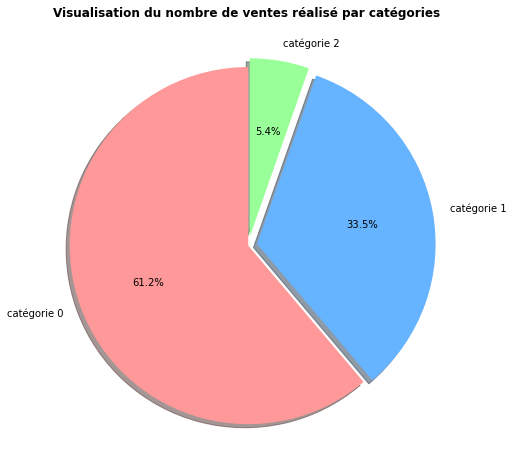

In [65]:
fig = plt.figure(figsize= [8,12])
labels = 'catégorie 0','catégorie 1','catégorie 2'

sizes=[Nb_vente_categ[0], 
       Nb_vente_categ[1],
       Nb_vente_categ[2]] 

explode = (0,0.05,0.05)  
ax = fig.add_subplot()

#add colors
colors = ['#ff9999','#66b3ff','#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Visualisation du nombre de ventes réalisé par catégories ',fontweight="bold")
plt.show()

## Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale

### Evolution par mois (plot)

In [66]:
df_transactions_customers_products_mois=df_transactions_customers_products['price'].resample('M').sum()

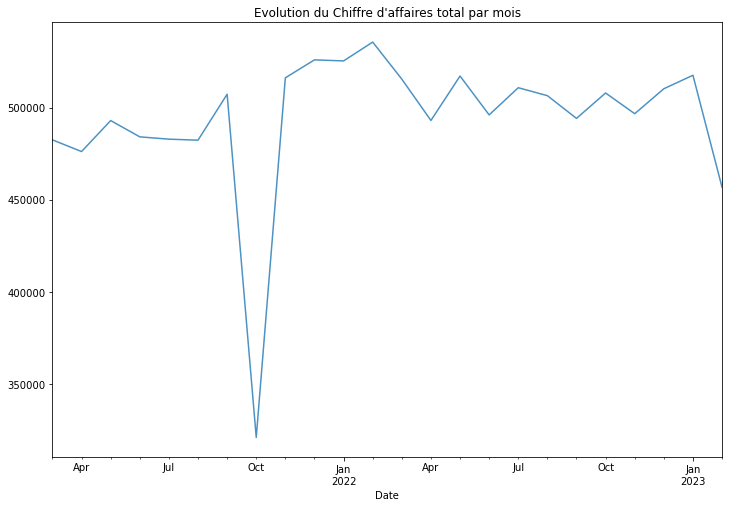

In [67]:
fig = plt.figure(figsize= [12,8])
df_transactions_customers_products_mois.plot(alpha=0.8)
plt.tick_params(axis='x')
plt.title("Evolution du Chiffre d'affaires total par mois")
plt.show()

In [68]:
# Resample par mois pour chaque categorie

df_transactions_customers_products_mois_categ_0 = df_transactions_customers_products[
    df_transactions_customers_products['categ'] == 0].resample('M').sum()

df_transactions_customers_products_mois_categ_1 = df_transactions_customers_products[
    df_transactions_customers_products['categ'] == 1].resample('M').sum()

df_transactions_customers_products_mois_categ_2 = df_transactions_customers_products[
    df_transactions_customers_products['categ'] == 2].resample('M').sum()

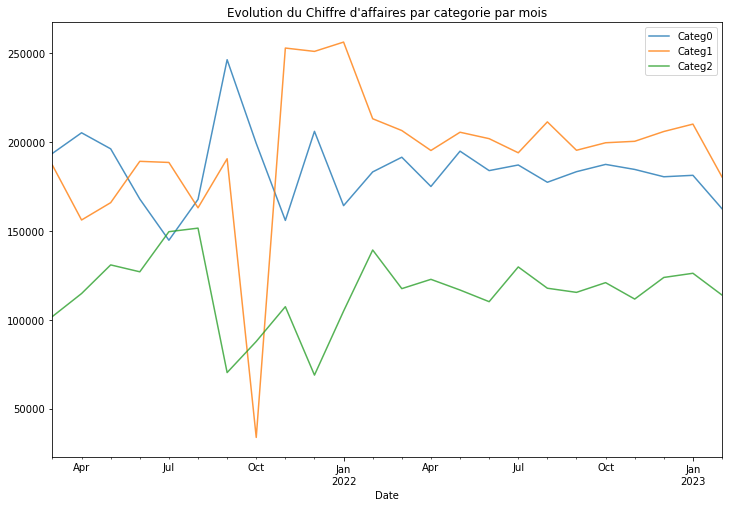

In [69]:
# visualisation plot
fig = plt.figure(figsize=[12, 8])
df_transactions_customers_products_mois_categ_0['price'].plot(alpha=0.8)
df_transactions_customers_products_mois_categ_1['price'].plot(alpha=0.8)
df_transactions_customers_products_mois_categ_2['price'].plot(alpha=0.8)
plt.tick_params(axis='x')
# Add legend
plt.legend(["Categ0","Categ1","Categ2"])
plt.title("Evolution du Chiffre d'affaires par categorie par mois")
plt.show()

### Evolution par mois (hist)

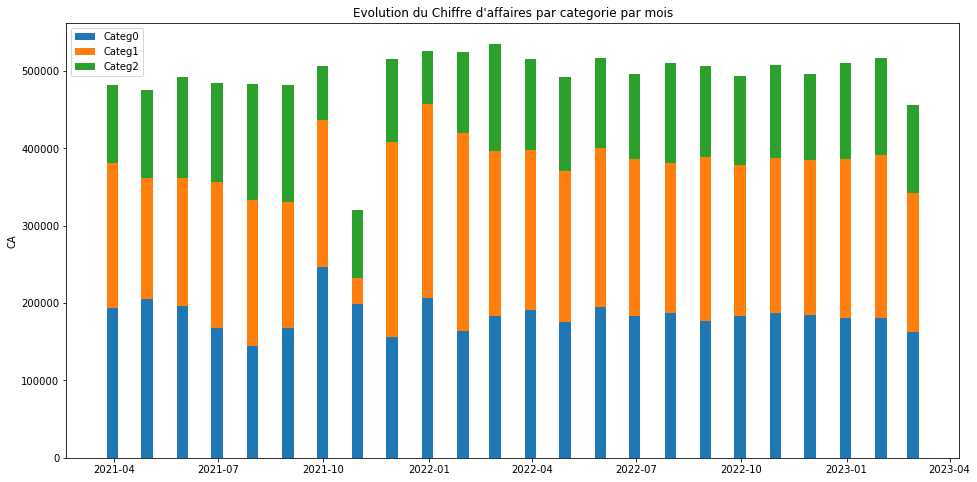

In [70]:
# visualisation hIST
fig = plt.figure(figsize=[16, 8])
# Define Data
Date = df_transactions_customers_products_mois_categ_0.index
Categ0 = df_transactions_customers_products_mois_categ_0['price']
Categ1 = df_transactions_customers_products_mois_categ_1['price']
Categ2 = df_transactions_customers_products_mois_categ_2['price']

# Define width of stacked chart
w = 10

# Plot stacked bar chart
plt.bar(Date, Categ0, w)
plt.bar(Date, Categ1, w, bottom=Categ0)
plt.bar(Date, Categ2, w, bottom=Categ0+Categ1)

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Categ0","Categ1","Categ2"])

# Display
plt.tick_params(axis='x')
plt.title("Evolution du Chiffre d'affaires par categorie par mois")
plt.show()

### Visualisation des données ou le CA est anormalement bas

In [71]:
#Visulation resample Jour de septembre à novembre 2021
df_transactions_customers_products_loc_sept_nov_2021 = df_transactions_customers_products.loc[
    '2021-09':'2021-11']['price'].resample('D').sum()

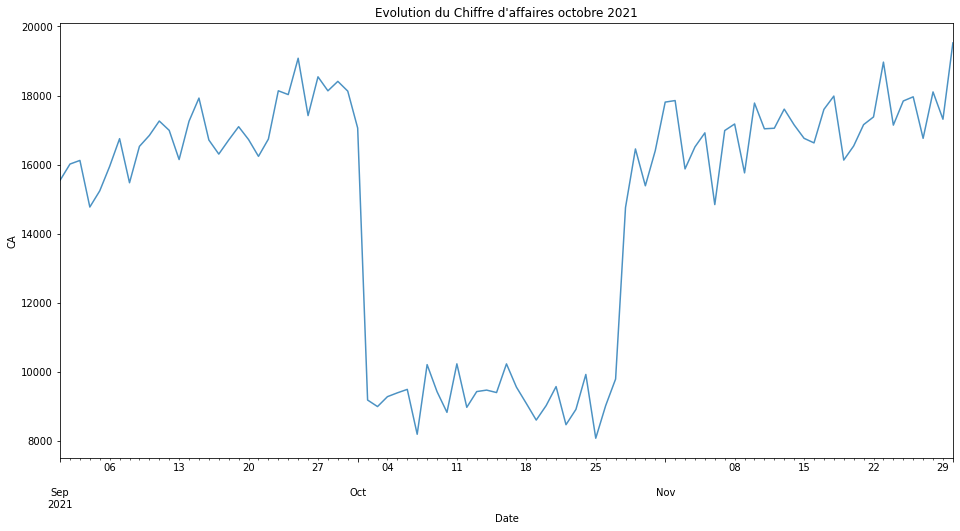

In [72]:
fig = plt.figure(figsize= [16,8])
df_transactions_customers_products_loc_sept_nov_2021.plot(alpha=0.8)
plt.tick_params(axis='x')
plt.ylabel("CA")
plt.title("Evolution du Chiffre d'affaires octobre 2021")
plt.show()

In [73]:
# Visulation resample Jour du 29 septembre au 29 octobre 2021
df_transactions_customers_products_loc_29_sept_29_oct_2021 = df_transactions_customers_products.loc[
    '2021-09-29':'2021-10-29']

In [74]:
df_transactions_customers_products_loc_29_sept_29_oct_2021_SOMME = df_transactions_customers_products_loc_29_sept_29_oct_2021['price'].resample(
    'D').sum()

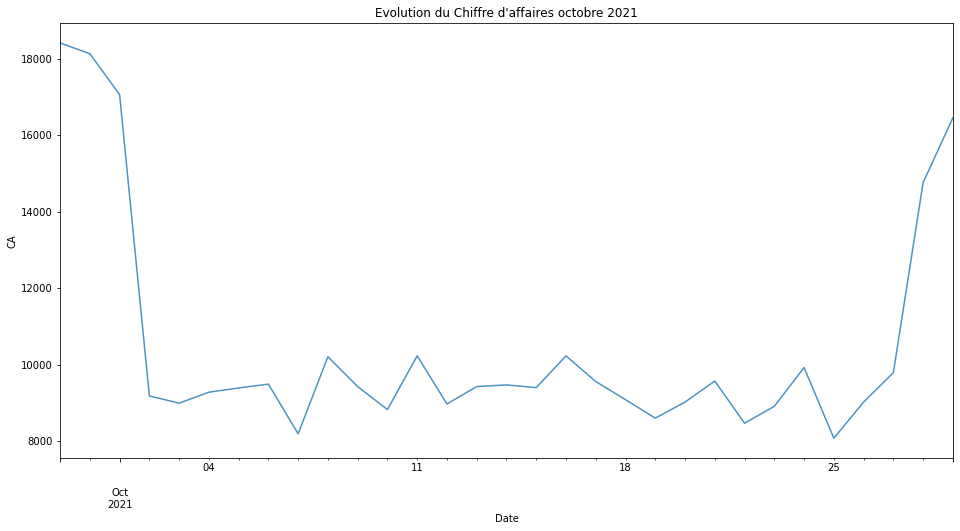

In [75]:
fig = plt.figure(figsize=[16, 8])
df_transactions_customers_products_loc_29_sept_29_oct_2021_SOMME.plot(
    alpha=0.8)
plt.ylabel("CA")
plt.title("Evolution du Chiffre d'affaires octobre 2021")
plt.show()

### Visualisation des données ou le CA est anormalement bas par categorie

In [76]:
# Resample Jour du 29 septembre au 29 octobre 2021 par categorie

df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_0 = df_transactions_customers_products_loc_29_sept_29_oct_2021[
    df_transactions_customers_products_loc_29_sept_29_oct_2021['categ'] == 0].resample('D').sum()

df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_1 = df_transactions_customers_products_loc_29_sept_29_oct_2021[
    df_transactions_customers_products_loc_29_sept_29_oct_2021['categ'] == 1].resample('D').sum()

df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_2 = df_transactions_customers_products_loc_29_sept_29_oct_2021[
    df_transactions_customers_products_loc_29_sept_29_oct_2021['categ'] == 2].resample('D').sum()

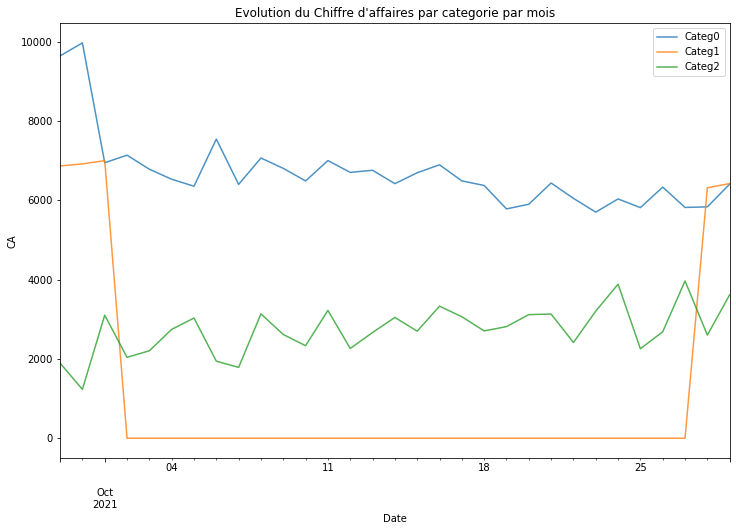

In [77]:
# visualisation plot
fig = plt.figure(figsize=[12, 8])
df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_0['price'].plot(alpha=0.8)
df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_1['price'].plot(alpha=0.8)
df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_2['price'].plot(alpha=0.8)
plt.tick_params(axis='x')
# Add legend
plt.legend(["Categ0","Categ1","Categ2"])
plt.ylabel("CA")
plt.title("Evolution du Chiffre d'affaires par categorie par mois")
plt.show()

In [78]:
df_transactions_customers_products_loc_29_sept_29_oct_2021_categ_1['price']

Date
2021-09-29    6870.45
2021-09-30    6920.45
2021-10-01    7003.79
2021-10-02       0.00
2021-10-03       0.00
2021-10-04       0.00
2021-10-05       0.00
2021-10-06       0.00
2021-10-07       0.00
2021-10-08       0.00
2021-10-09       0.00
2021-10-10       0.00
2021-10-11       0.00
2021-10-12       0.00
2021-10-13       0.00
2021-10-14       0.00
2021-10-15       0.00
2021-10-16       0.00
2021-10-17       0.00
2021-10-18       0.00
2021-10-19       0.00
2021-10-20       0.00
2021-10-21       0.00
2021-10-22       0.00
2021-10-23       0.00
2021-10-24       0.00
2021-10-25       0.00
2021-10-26       0.00
2021-10-27       0.00
2021-10-28    6317.99
2021-10-29    6425.18
Freq: D, Name: price, dtype: float64

Les valeurs de la categorie 1 sont nulles **du 2 au 27 octobre inclus**, certainement une erreur. Nous pouvons nuancer notre caclul précédent concernant de chiffre d'affaires avec ce manque de données
<br> Nous pouvons emetre des hypothèses ( rupture de stock livres de la categorie 1, données non transmises..)

## Faire un zoom sur les références, 
### Les tops et les flops sur l'ensemble des produits

In [79]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_prod = df_transactions_customers_products.groupby(
    'id_prod')['price'].sum().sort_values(ascending=False)

# selection des 20 premières valeurs
df_transactions_customers_products_id_prod_top_20 = df_transactions_customers_products_id_prod[
    :20]

Nous observons que les produits de la categ 2 sont ceux qui composent le top de notre classement sur l'ensemble des références. Comme nous pouvions le voir precedement il s'agit de la categorie ou la quantité de produits vendus est la plus faible avec seulement 6% des produits soit 36483 produits

In [81]:
# Groupby id_prod et sort_value price ascending true
df_transactions_customers_products_id_prod = df_transactions_customers_products.groupby(
    'id_prod')['price'].sum().sort_values(ascending=True)

# selection des 20 premières valeurs
df_transactions_customers_products_id_prod_flop_20 = df_transactions_customers_products_id_prod[
    :20]

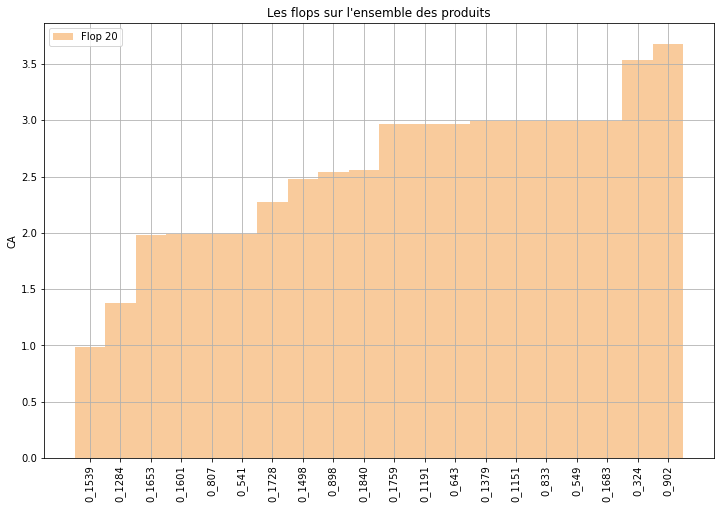

In [82]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_20.index
flop20 = df_transactions_customers_products_id_prod_flop_20.values

# Bar
plt.bar(id_prod, flop20, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur l'ensemble des produits")
plt.grid()
plt.show()

Tandis que les produits de la categorie 0 composent le flop 20 du classement sur l'ensemble des produits. Comme nous pouvions le voir precedement il s'agit de la categorie ou la quantité de produits vendus est la plus forte avec 61% des produits soit 415459 produits

## Les tops et les flops par categorie

### Top Categorie 0,1 et 2

In [83]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_prod_categ = df_transactions_customers_products.groupby(
    ['id_prod', 'categ'])['price'].sum().sort_values(ascending=False)

# pd to dataframe
df_transactions_customers_products_id_prod_categ = pd.DataFrame(
    df_transactions_customers_products_id_prod_categ)

# reset index categ
df_transactions_customers_products_id_prod_categ = df_transactions_customers_products_id_prod_categ.reset_index(
    'categ')

# fillna
df_transactions_customers_products_id_prod_categ = df_transactions_customers_products_id_prod_categ.fillna(
    0)

In [84]:
# filtre categ O
df_transactions_customers_products_id_prod_categ_0 = df_transactions_customers_products_id_prod_categ[
    df_transactions_customers_products_id_prod_categ['categ'] == 0]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_categ_0_top_20 = df_transactions_customers_products_id_prod_categ_0[
    :20]

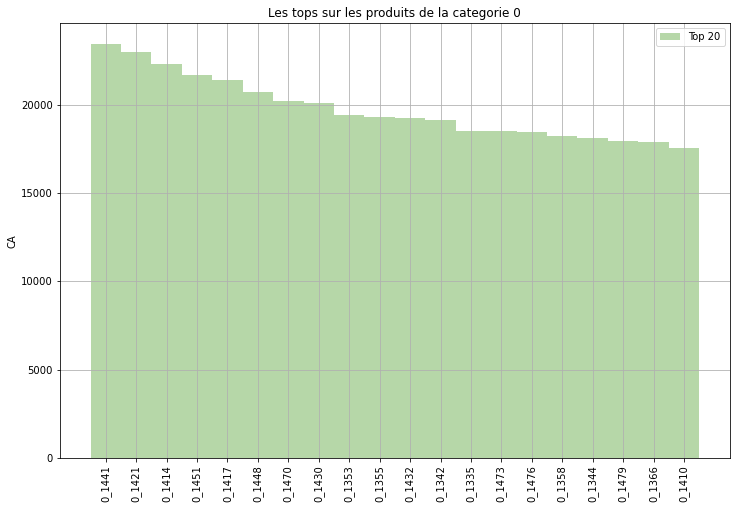

In [85]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_categ_0_top_20.index
top20 = df_transactions_customers_products_id_prod_categ_0_top_20['price'].values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur les produits de la categorie 0")
plt.grid()
plt.show()

In [86]:
# filtre categ 1
df_transactions_customers_products_id_prod_categ_1 = df_transactions_customers_products_id_prod_categ[
    df_transactions_customers_products_id_prod_categ['categ'] == 1]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_categ_1_top_20 = df_transactions_customers_products_id_prod_categ_1[
    :20]

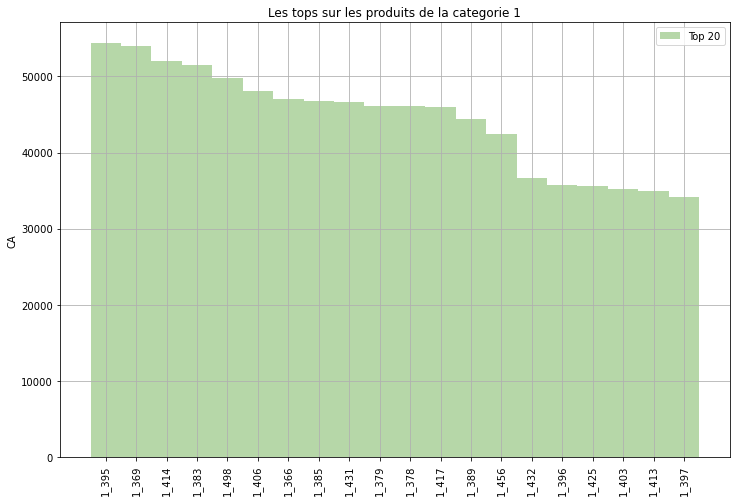

In [87]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_categ_1_top_20.index
top20 = df_transactions_customers_products_id_prod_categ_1_top_20['price'].values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur les produits de la categorie 1")
plt.grid()
plt.show()

In [88]:
# filtre categ 1
df_transactions_customers_products_id_prod_categ_2 = df_transactions_customers_products_id_prod_categ[
    df_transactions_customers_products_id_prod_categ['categ'] == 2]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_categ_2_top_20 = df_transactions_customers_products_id_prod_categ_2[
    :20]

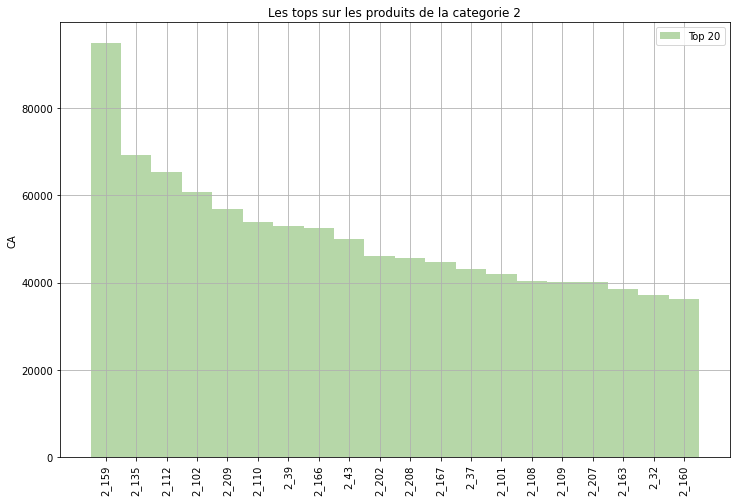

In [89]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_categ_2_top_20.index
top20 = df_transactions_customers_products_id_prod_categ_2_top_20['price'].values

# Bar
plt.bar(id_prod, top20, w,color = "#b6d7a8")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Top 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les tops sur les produits de la categorie 2")
plt.grid()
plt.show()

Nous observons un interet très marqué pour un produit id_prod = 2_159, ce produit réalise 650 ventes avec un prix unitaire 145.99 eur

In [90]:
df_transactions_customers_products[df_transactions_customers_products['id_prod']=='2_159']

,id_prod,date,session_id,client_id,sex,birth,price,categ,ANNEE,MOIS,JOUR,age
Date,,,,,,,,,,,,
2021-06-17,2_159,2021-06-17 02:00:45.520595,s_49681,c_6714,f,1968,145.99,2,2021,June,Thursday,54
2022-03-08,2_159,2022-03-08 02:29:58.487313,s_176011,c_6714,f,1968,145.99,2,2022,March,Tuesday,54
2022-04-12,2_159,2022-04-12 06:47:01.040907,s_192824,c_6714,f,1968,145.99,2,2022,April,Tuesday,54
2023-01-31,2_159,2023-01-31 18:42:22.344911,s_335076,c_6714,f,1968,145.99,2,2023,January,Tuesday,54
2022-06-01,2_159,2022-06-01 12:08:48.215144,s_217228,c_6714,f,1968,145.99,2,2022,June,Wednesday,54
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,2_159,2022-04-29 10:53:43.251138,s_201053,c_1821,m,2003,145.99,2,2022,April,Friday,19
2021-03-28,2_159,2021-03-28 01:50:16.302343,s_12426,c_275,f,1951,145.99,2,2021,March,Sunday,71
2021-11-18,2_159,2021-11-18 05:08:14.659797,s_121327,c_2105,f,1951,145.99,2,2021,November,Thursday,71


### Flop Categorie 0,1 et 2

In [91]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_prod_categ_flop = df_transactions_customers_products.groupby(
    ['id_prod', 'categ'])['price'].sum().sort_values(ascending=True)

# pd to dataframe
df_transactions_customers_products_id_prod_categ_flop  = pd.DataFrame(
    df_transactions_customers_products_id_prod_categ_flop )

# reset index categ
df_transactions_customers_products_id_prod_categ_flop  = df_transactions_customers_products_id_prod_categ_flop .reset_index(
    'categ')

# fillna
df_transactions_customers_products_id_prod_categ_flop  = df_transactions_customers_products_id_prod_categ_flop .fillna(
    0)

In [92]:
# filtre categ 0
df_transactions_customers_products_id_prod_flop_categ_0 = df_transactions_customers_products_id_prod_categ_flop[
    df_transactions_customers_products_id_prod_categ_flop['categ'] == 0]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_flop_categ_0_top_20 = df_transactions_customers_products_id_prod_flop_categ_0[
    :20]

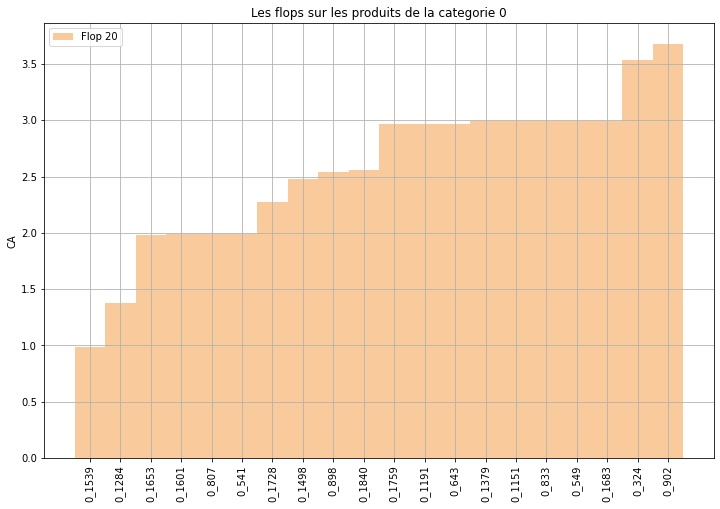

In [93]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_0_top_20.index
categ_0_flop = df_transactions_customers_products_id_prod_flop_categ_0_top_20['price'].values

# Bar
plt.bar(id_prod, categ_0_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 0")
plt.grid()
plt.show()

In [94]:
# filtre categ 1
df_transactions_customers_products_id_prod_flop_categ_1 = df_transactions_customers_products_id_prod_categ_flop[
    df_transactions_customers_products_id_prod_categ_flop['categ'] == 1]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_flop_categ_1_top_20 = df_transactions_customers_products_id_prod_flop_categ_1[
    :20]

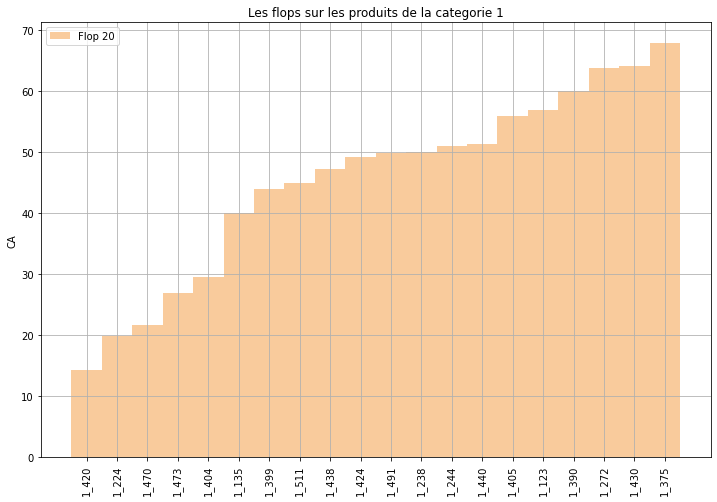

In [95]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_1_top_20.index
categ_1_flop = df_transactions_customers_products_id_prod_flop_categ_1_top_20['price'].values

# Bar
plt.bar(id_prod, categ_1_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 1")
plt.grid()
plt.show()

In [96]:
# filtre categ 2
df_transactions_customers_products_id_prod_flop_categ_2 = df_transactions_customers_products_id_prod_categ_flop[
    df_transactions_customers_products_id_prod_categ_flop['categ'] == 2]

# selection des 20 premières valeurs categ 0
df_transactions_customers_products_id_prod_flop_categ_2_top_20 = df_transactions_customers_products_id_prod_flop_categ_2[
    :20]

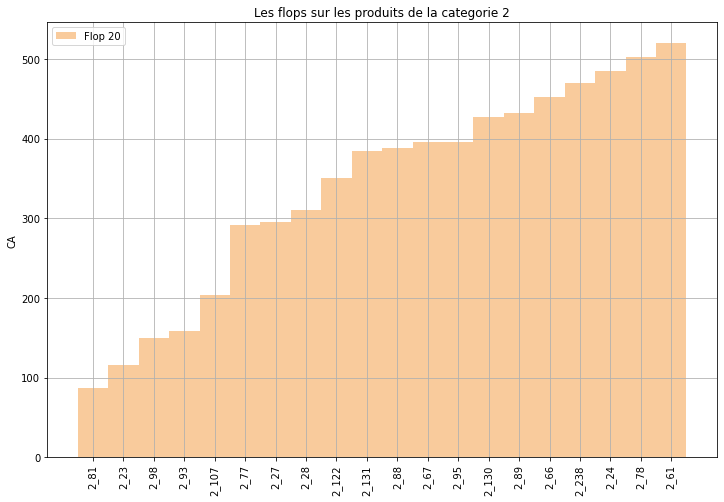

In [97]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_2_top_20.index
categ_2_flop = df_transactions_customers_products_id_prod_flop_categ_2_top_20['price'].values

# Bar
plt.bar(id_prod, categ_2_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 2")
plt.grid()
plt.show()

## La répartition par catégorie

## Informations sur les profils de nos clients

In [105]:
# Groupby id_prod et sort_value price ascending false
df_transactions_customers_products_id_client = df_transactions_customers_products.groupby(
    'client_id')['price'].sum().sort_values(ascending=False)


# pd to dataframe
df_transactions_customers_products_id_client  = pd.DataFrame(
    df_transactions_customers_products_id_client )


In [107]:
df_transactions_customers_products_id_client

,price
client_id,
c_1609,324033.35
c_4958,289760.34
c_6714,153598.92
c_3454,113637.93
c_3263,5276.87
...,...
c_4648,11.20
c_240,11.06
c_8114,9.98


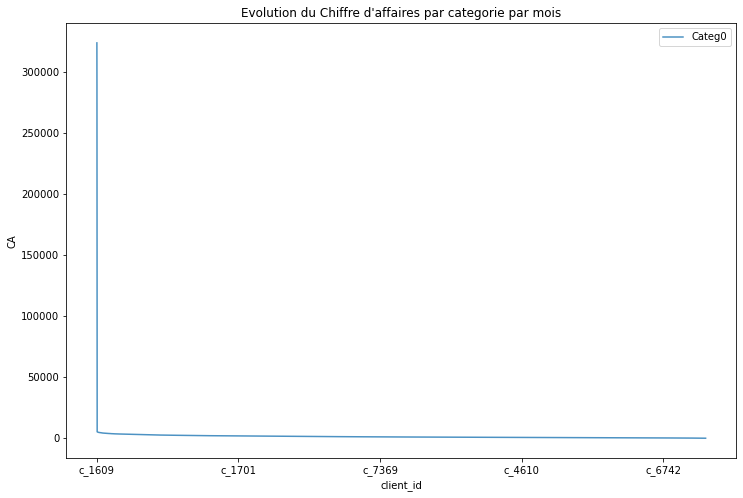

In [106]:
# visualisation hist
fig = plt.figure(figsize=[12, 8])

# Define width of stacked chart
w = 1

# Define Data
id_prod = df_transactions_customers_products_id_prod_flop_categ_2_top_20.index
categ_2_flop = df_transactions_customers_products_id_prod_flop_categ_2_top_20['price'].values

# Bar
plt.bar(id_prod, categ_2_flop, w,color = "#f9cb9c")

# Add labels
plt.ylabel("CA")

# Add legend
plt.legend(["Flop 20"])

# Display
plt.tick_params(axis='x',rotation=90)
plt.title("Les flops sur les produits de la categorie 2")
plt.grid()
plt.show()

In [100]:
df_client_c_4958=df_transactions_customers_products[df_transactions_customers_products['client_id']=='c_4958']

df_client_c_1609=df_transactions_customers_products[df_transactions_customers_products['client_id']=='c_1609']

In [101]:
df_client_c_4958.groupby(
    ['client_id','age','categ'])['price'].sum().sort_values(ascending=False)

client_id  age  categ
c_4958     23   2        250336.34
                1         39375.24
                0            48.76
Name: price, dtype: float64

In [102]:
df_client_c_1609.groupby(
    ['client_id','age','categ'])['price'].sum().sort_values(ascending=False)

client_id  age  categ
c_1609     42   0        214447.24
                1        108084.90
                2          1501.21
Name: price, dtype: float64

## La répartition du chiffre d'affaires

In [ ]:
## Concentration CA (Lorenz)
dep = TDF['CA']
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
#Graphique concentration dU CA
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA total",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA")
plt.grid()
plt.show()

## La répartition du chiffre d'affaires par catégorie

In [ ]:
dep = TDF[('price', 0)]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA cat 0",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA cat 0")
plt.grid()
plt.show()

In [ ]:
dep = TDF[('price', 1)]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA cat 1",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA cat 1")
plt.grid()
plt.show()

In [ ]:
dep = TDF[('price', 2)]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

In [ ]:
plt.figure(figsize= [8,8])
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - CA cat 2",fontweight="bold")
ax.set_xlabel("Produit")
ax.set_ylabel("CA cat 2")
plt.grid()
plt.show()

On peut observer que :

* La catégorie 1 à la répartition du CA la plus égalitaire 
* La catégorie 2 à la répartition du CA la plus inégalitaire

## Le lien entre le genre d’un client et les catégories des livres achetés

In [ ]:
TDC =pd.pivot_table(df, index=['categ'], columns=['sex'],values=['age','price'], aggfunc={'age' :np.mean, 'price': np.mean})

TDC

On peut observer que :
* La catégorie 0 à en moyenne le plus petit  panier moyen (10eur) avec une moyenne d'age femme/homme entre 44 et 43 ans
* La catégorie 1 à un panier moyen à 20eur avec une moyenne d'age la plus elevée femme/homme entre 48 et 46 ans
* La catégorie 2 à un panier moyen le plus elevé à 75eur avec une moyenne d'age  femme/homme entre 26 et 25 ans

In [ ]:
fig = plt.figure(figsize= [8,12])
sns.set_style('whitegrid')
sns.countplot(x='categ', hue='sex', data=df, palette='Blues')

## Le lien entre l’âge des clients et le montant total des achats

In [ ]:
fig = plt.figure(figsize= [20,8])
sns.set_style('whitegrid')
sns.countplot(x='age', data=df, palette='dark:salmon_r')

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='categ', y= 'age', data=df, palette="Spectral" )

## La fréquence d’achat

In [ ]:
#Pivot table
TBG = df.pivot_table(index = ['session_id'],columns=['Date'],values=['price'], aggfunc={'price': np.mean})

#fillna()
TBG =TBG.fillna(0)

In [ ]:
BG_transposed = TBG.T

In [ ]:
TBG_transposed=TBG_transposed.reset_index()

In [ ]:
TBG_transposed.drop(['level_0'], axis=1,inplace=True)

In [ ]:
freq=TBG['session_id'].value_counts(normalize=True)*100

In [ ]:
freq

In [ ]:
TBG

## La fréquence d’achat / categ

In [ ]:
plt.figure(figsize=(12,8))
TBG .loc['2021':'2023']['session_id'].plot(alpha=0.8)
TBG .loc['2021':'2023']['session_id'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TBG .loc['2021':'2023']['session_id'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
TBG .loc['2021':'2023']['price'].plot(alpha=0.8)
TBG .loc['2021':'2023']['price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TBG .loc['2021':'2023']['price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()

## La taille du panier moyen et les catégories des livres achetés

In [ ]:
TBG

# Imputation

In [ ]:
plt.figure(figsize=(12,8))
TDA.loc['2021-09':'2021-11']['price'].plot(alpha=0.8)
TDA.loc['2021-09':'2021-11']['price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TDA.loc['2021-09':'2021-11']['price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de septembre à novembre 2021',fontweight="bold")
plt.legend()
plt.show()

In [ ]:
m=TDA['2021-09':'2021-11']['price'].resample('W').agg(['mean','min','max'])

plt.figure(figsize=(12,8))
m['mean']['2021-09':'2021-11'].plot(label='Moyenne par semaine')
plt.fill_between(m.index,m['max'],m['min'],alpha=0.2, label='min - max par semaine')
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()


# Building a Regression model